# Final Report

## 1. Executive Summary

## 2. Aim and Background

### 2.1. Problem

### 2.2. Aim

## 3. Methods


### 3.1. Data Collection

In [1]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import signal
import seaborn as sns

In [59]:
# CONFIG

EVENT_ID_MAP = {
    None: 0,
    "L": 1,
    "R": 2,
    "S": 3,
}
EVENT_ID_LETTER_MAP = {EVENT_ID_MAP[i]:i for i in EVENT_ID_MAP}

EVENT_COLOR_MAP = {
    None: "black",
    "L": "red",
    "R": "blue",
    "S": "green",
}

EVENT_ID_NAME_MAP = {
    0: "Nothing",
    1: "Left Wink",
    2: "Right Wink",
    3: "Dbl Blink",
}

BRAINBOX_SAMPLE_RATE = 10000

DOWNSAMPLE_RATE = 100

FILTER_DATA = True
FILTER_CUTOFF = 7

NORMALISE_DATA = True

EVENT_LENGTH = 2 # length of a given event sequence in seconds
EVENT_SAMPLE_COUNT = int(EVENT_LENGTH * BRAINBOX_SAMPLE_RATE / DOWNSAMPLE_RATE) # size of event in samples

EVENT_START = -0.75
EVENT_START_OFFSET = int(EVENT_START * BRAINBOX_SAMPLE_RATE / DOWNSAMPLE_RATE)

EVENT_END = -0.25
EVENT_END_OFFSET = int(EVENT_END * BRAINBOX_SAMPLE_RATE / DOWNSAMPLE_RATE)

INPUT_SHAPE = (EVENT_SAMPLE_COUNT,)
OUTPUT_SHAPE = len(EVENT_ID_MAP)  # number of categories (including None)

EVENTS_PATH = "../src/data_collection/data/events/"
SAMPLES_PATH = "../src/data_collection/data/waves/"

FILE_NAMES_ALL = [
    "DATA_2022-05-13_Josh_0001_3_1652400625",
#     "DATA_2022-05-13_Josh_0001_3_1652400939",
    "DATA_2022-05-13_Josh_0001_4_1652401267",
#     "DATA_2022-05-13_Josh_0001_4_1652401740",
    "DATA_2022-05-13_Josh_0001_5_1652405337",
#     "DATA_2022-05-13_Josh_0001_5_1652405637",
#     "DATA_2022-05-13_Josh_0001_6_1652406023",
#     "DATA_2022-05-13_Josh_0001_6_1652406202",
#     "DATA_2022-05-13_Josh_0001_7_1652406589",
#     "DATA_2022-05-13_Josh_0001_7_1652406788",
#     "DATA_2022-05-13_Josh_0001_8_1652407331",
#     "DATA_2022-05-13_Josh_0001_8_1652407508",
]

In [60]:
def load_sample_data(file_path:str):
    samples_df = pd.read_csv(
        f"{file_path}.csv",
    )

    # Sort because some samples are not written in order
    samples_df = samples_df.sort_values("time_sec", ascending=True)
    samples_df.reset_index(drop=True, inplace=True)

    return samples_df

In [61]:
def load_event_data(file_path:str, event_id_map:dict, event_color_map:dict):
    """ Reads brainbox event data into a data frame """

    events_df = pd.read_csv(
        f"{file_path}.csv",
        names=["time_sec", "event_letter", "event_name"],
        header=0,
    )

    events_df["event_id"] = events_df["event_letter"].map(event_id_map)
    events_df["event_color"] = events_df["event_letter"].map(event_color_map)

    return events_df

In [62]:
def merge_samples_events(
    samples_df,
    events_df,
    event_start:float,
    event_end:float,
    event_id_map:dict,
    event_color_map:dict,
):
    """
    Merges the sample and event dataframes.

    Events will be assigned to individual samples within a specified time range around the market.
    """
    # Add target classification event to each sample
    merge_df = samples_df.copy()

    # Default is None (no event)
    merge_df["event_letter"] = None
    merge_df["event_name"] = "Nothing"
    merge_df["event_id"] = event_id_map[None]
    merge_df["event_color"] = event_color_map[None]
    #print(sample_100_df)

    # Assign all events within range around their event marker
    for idx,row in events_df.iterrows():
        # Skip blinks for now
        # if row["event_type"] not in ["Left", "Right"]:
        #     continue

        event_interval = (merge_df["time_sec"] > (row["time_sec"] + event_start))
        event_interval &= (merge_df["time_sec"] < (row["time_sec"] + event_end))
        
        merge_df.loc[event_interval,"event_id"] = row["event_id"]
        merge_df.loc[event_interval,"event_name"] = row["event_name"]
        merge_df.loc[event_interval,"event_color"] = row["event_color"]

    return merge_df

### 3.2. Data Preprocessing

#### 3.2.1. Downsampling

In [63]:
def data_downsample(sample_df, n=100):
    """
    Downsamples the wave data (not events) to 1/nth of a second by taking mean sample over that period.
    """
    # Crop size to allow downsampling
    sample_df = sample_df[:len(sample_df) - (len(sample_df)%n)]
    
    return pd.DataFrame({
        "time_sec": np.min(np.array(sample_df["time_sec"]).reshape(-1,n), 1),
        "sample": np.mean(np.array(sample_df["sample"]).reshape(-1,n), 1),
    })

#### 3.2.2. Data Segmentation

In [66]:
def data_segmentation(merge_df, event_sample_count:int, filter_data:bool):
    """
    Returns a list of each time series sequence labelled by the event.
    """
    print("Transforming data into individual sequences...")

    seqs = []
    labels = []

    for idx,row in merge_df[:-event_sample_count].iterrows():
        label = row["event_id"]
        if label is None:
            label = -1
        labels.append(label)

        seq = list(merge_df["sample"][idx:idx+event_sample_count])
        seqs.append(seq)

    seqs = np.array(seqs)
    labels = np.array(labels)

    print(f"Transformed into {seqs.shape[0]} sequences of size {seqs.shape[1]}")
    
    return (seqs, labels)

#### 3.2.3. Filter

In [64]:
# Butterworth filter
def data_filter(rawData, order:int=5, cutOff:int=7, Fs:int=10000):
    """
    Low pass
    cutOff in Hz
    """
    b, a = signal.butter(order, Wn=cutOff/(Fs/2)) 
    # Zero Phase double filter
    filteredSignal = signal.filtfilt(b, a, rawData)
    return filteredSignal

#### 3.2.4. Normalising

In [65]:
def data_normalise(data):
    return (data - data.mean()) / data.std()

In [68]:
print("Data Preprocessing")
files_data_all = []
files_labels_all = []

for file_name in FILE_NAMES_ALL:
    start_time = time.time()

    print(f"Loading sample file '{file_name}'")
    samples_df = load_sample_data(SAMPLES_PATH + file_name)
    print(f"Loaded {len(samples_df)} samples")
    
    print(f"Downsampling @ n={DOWNSAMPLE_RATE}")
    samples_df = data_downsample(samples_df, n=DOWNSAMPLE_RATE)
    print(f"Downsampled to {len(samples_df)} samples")

    print(f"Loading event file '{file_name}'")
    events_df = load_event_data(
        file_path = EVENTS_PATH + file_name,
        event_id_map = EVENT_ID_MAP,
        event_color_map = EVENT_COLOR_MAP,
    )
    print(f"Loaded {len(events_df)} events")

    print(f"Merging samples and events")
    merge_df = merge_samples_events(
        samples_df, events_df,
        event_start = EVENT_START,
        event_end = EVENT_END,
        event_id_map = EVENT_ID_MAP,
        event_color_map = EVENT_COLOR_MAP,
    )
#     print("Merge complete")

    # Segment data for ML model input
    seq_data, seq_labels = data_segmentation(
        merge_df,
        event_sample_count=EVENT_SAMPLE_COUNT,
        filter_data=FILTER_DATA,
    )

    # Apply filters before we do the normalisation
    # One reason is that mains 50Hz will increase std for that sample
    if FILTER_DATA:
        for i,seq in enumerate(seq_data):
            seq_data[i] = data_filter(seq, cutOff=FILTER_CUTOFF, Fs=100) # Account for downsampling

    # Normalise relative to the 2 second interval
    # Note that this method will scale non-actions to have large magnitudes
    if NORMALISE_DATA:
        for i,seq in enumerate(seq_data):
            seq_data[i] = data_normalise(seq)

    files_data_all.append(seq_data)
    files_labels_all.append(seq_labels)

    print(f"Loaded and preprocessed file data in {time.time()-start_time:.2f}s")
    print("")

Data Preprocessing
Loading sample file 'DATA_2022-05-13_Josh_0001_3_1652400625'
Loaded 1924764 samples
Downsampling @ n=100
Downsampled to 19247 samples
Loading event file 'DATA_2022-05-13_Josh_0001_3_1652400625'
Loaded 52 events
Merging samples and events
Transforming data into individual sequences...
Transformed into 19047 sequences of size 200
Loaded and preprocessed file data in 6.05s

Loading sample file 'DATA_2022-05-13_Josh_0001_4_1652401267'
Loaded 2180967 samples
Downsampling @ n=100
Downsampled to 21809 samples
Loading event file 'DATA_2022-05-13_Josh_0001_4_1652401267'
Loaded 53 events
Merging samples and events
Transforming data into individual sequences...
Transformed into 21609 sequences of size 200
Loaded and preprocessed file data in 6.80s

Loading sample file 'DATA_2022-05-13_Josh_0001_5_1652405337'
Loaded 2466785 samples
Downsampling @ n=100
Downsampled to 24667 samples
Loading event file 'DATA_2022-05-13_Josh_0001_5_1652405337'
Loaded 63 events
Merging samples and ev

### 3.3. Models

In [69]:
import tensorflow as tf

def get_model_ann():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=INPUT_SHAPE),
        tf.keras.layers.Dropout(.50, input_shape=INPUT_SHAPE),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(OUTPUT_SHAPE)
    ])
    return model
get_model_ann().summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 200)               0         
                                                                 
 dropout_4 (Dropout)         (None, 200)               0         
                                                                 
 dense_12 (Dense)            (None, 64)                12864     
                                                                 
 dense_13 (Dense)            (None, 16)                1040      
                                                                 
 dense_14 (Dense)            (None, 4)                 68        
                                                                 
Total params: 13,972
Trainable params: 13,972
Non-trainable params: 0
_________________________________________________________________


#### 3.3.2. SVM

In [70]:
from sklearn import svm

def get_model_svm():
    clf = svm.SVC()
    return clf

#### 3.3.3 Random Forest

In [71]:
from xgboost import XGBRFClassifier

# Hyper-Parameters
RF_N_TREES = [10,50,100,500,1000,5000]
RF_N_FEATURES = [x for x in np.arange(0.1, 1.1, 0.1)]

def get_model_rf(num_trees=50, num_features=0.1):
    return XGBRFClassifier(
        n_estimators=num_trees,
        subsample=0.9,
        colsample_bynode=num_features
    )

### 3.4. Evaluation Strategy

In [72]:
ANN_EPOCHS = 3
ANN_OPTIMIZER = 'adam'

def train_model_ann(model, train_data, train_labels, test_data, test_labels):
    print("Training ANN with", len(train_labels), "samples")
    start_time = time.time()
    
    # Trains model and returns history dict
    model.compile(
        optimizer=ANN_OPTIMIZER,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    history = model.fit(
        train_data,
        train_labels,
        epochs=ANN_EPOCHS,
        validation_data=(test_data, test_labels)
    #     batch_size=16
    )

    print(f"Completed training ANN in {time.time()-start_time:.2f}s")

    print(f"Generating predictions for test set", len(test_labels))
    start_time = time.time()
    
    test_out = model.predict(test_data)
    test_probs = tf.nn.softmax(test_out, axis=1)
    test_pred = np.argmax(test_probs, axis=1)
    
    print(f"Generated predictions in {time.time()-start_time:.2f}s")

    # Return predictions for test set
    return test_pred

In [73]:
def train_model_svm(model, train_data, train_labels, test_data, test_labels):
    subset = np.random.random(len(train_data)) < 0.1
    print("Training SVM with", sum(subset), "samples")
    start_time = time.time()
    
    model.fit(train_data[subset], train_labels[subset])
    
    print(f"Completed training SVM in {time.time()-start_time:.2f}s")

    print(f"Generating predictions for test set", len(test_labels))
    start_time = time.time()
    
    test_pred = model.predict(test_data)

    print(f"Generated predictions in {time.time()-start_time:.2f}s")
    
    # Return predictions for test set
    return test_pred

In [74]:
# Random Forest Training and Testing
def train_model_xgbrf(model, train_data, train_labels, test_data, test_labels):
    print("Training XGBRandomForest with", len(train_data), "samples")
    start_time = time.time()
    
    model.fit(train_data, train_labels)
    
    print(f"Completed training XGBRandomForest in {time.time()-start_time:.2f}s")
    
    print(f"Generating predictions for test set", len(test_labels))
    
    start_time = time.time()
    
    test_pred = model.predict(test_data)
    
    print(f"Generated predictions in {time.time()-start_time:.2f}s")

    # Return predictions for test set
    return test_pred

In [75]:
def confusion_matrix(label_pred, label_true):
    # Rows are "real" labels
    # Columns are "predicted" labels
    conf = tf.math.confusion_matrix(
        label_pred,
        label_true
    )

    return conf

In [76]:
CV_K = len(FILE_NAMES_ALL)

cv_conf_ann = []
cv_conf_svm = []
cv_conf_rf = []

for k in range(CV_K):
    print(f"Fold #{k+1}/{CV_K}")
    start_time = time.time()
    
    # Get training data/labels
    train_data = np.concatenate(files_data_all[0:k] + files_data_all[k+1:])
    train_labels = np.concatenate(files_labels_all[0:k] + files_labels_all[k+1:])
    print(train_data.shape, train_labels.shape)
    
    test_data = files_data_all[k]
    test_labels = files_labels_all[k]
    print(test_data.shape, test_labels.shape)

    # Train and test ANN
    model_ann = get_model_ann()
    test_pred_ann = train_model_ann(model_ann, train_data, train_labels, test_data, test_labels)
    conf_ann = confusion_matrix(test_pred_ann, test_labels)
    cv_conf_ann.append(conf_ann)
    
    # Train and test SVM
    model_svm = get_model_svm()
    test_pred_svm = train_model_svm(model_svm, train_data, train_labels, test_data[:10000], test_labels[:10000])
    conf_svm = confusion_matrix(test_pred_svm, test_labels[:10000])
    cv_conf_svm.append(conf_svm)
    
    # Train and Test XGBRandomForest
    model_xgbrf = get_model_rf()
    test_pred_xgbrf = train_model_xgbrf(model_xgbrf, train_data, train_labels, test_data, test_labels)
    conf_xgbrf = confusion_matrix(test_pred_xgbrf, test_labels)
    cv_conf_rf.append(conf_xgbrf)

    print(f"Done fold in {time.time() - start_time:.2f}s\n")

Fold #1/3
(46076, 200) (46076,)
(19047, 200) (19047,)
Training ANN with 46076 samples
Epoch 1/3
1440/1440 [==============================] - 2s 1ms/step - loss: 0.2456 - accuracy: 0.9078 - val_loss: 0.2035 - val_accuracy: 0.9332
Epoch 2/3
1440/1440 [==============================] - 2s 1ms/step - loss: 0.1480 - accuracy: 0.9442 - val_loss: 0.1663 - val_accuracy: 0.9457
Epoch 3/3
1440/1440 [==============================] - 2s 1ms/step - loss: 0.1257 - accuracy: 0.9526 - val_loss: 0.1815 - val_accuracy: 0.9388
Completed training ANN in 5.51s
Generating predictions for test set 19047
Generated predictions in 0.31s
Training SVM with 4708 samples
Completed training SVM in 0.87s
Generating predictions for test set 10000
Generated predictions in 2.54s
Training XGBRandomForest with 46076 samples
Completed training XGBRandomForest in 3.05s
Generating predictions for test set 19047
Generated predictions in 0.01s
Done fold in 12.37s

Fold #2/3
(43514, 200) (43514,)
(21609, 200) (21609,)
Training

In [78]:
print(cv_conf_ann)
print(cv_conf_svm)
print(cv_conf_rf)

[<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[16047,   420,    93,   216],
       [   77,   313,     0,    24],
       [  239,     0,   809,     0],
       [   79,    17,     0,   713]], dtype=int32)>, <tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[18374,   183,   167,   174],
       [  336,  1019,     0,     8],
       [  191,     0,   482,     0],
       [   72,     0,     0,   603]], dtype=int32)>, <tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[20843,   241,   192,   381],
       [  191,   644,     0,    69],
       [  233,     0,  1261,     0],
       [   44,    67,     0,   301]], dtype=int32)>]
[<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[8609,  167,   74,  281],
       [   7,  128,    0,    0],
       [  80,    0,  477,    0],
       [   1,    5,    0,  171]], dtype=int32)>, <tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[8617,  135,  106,   73],
       [  99,  317,    0,    0],
       [  65,    0,  293,    0],
       [  17,    0,    0,  27

## 4. Results

### 4.1. Part A

In [79]:
def print_confusion_matrix(conf):
    print(conf)
    
    overall_total = sum(sum(conf))
    overall_correct = sum([conf[i][i] for i in range(len(conf))])
    print(f"Overall accuracy: {100*overall_correct/overall_total:.2f}% ({overall_correct}/{overall_total})")
    
    fp = sum(conf[0][1:])
    tp = sum(sum(conf[1:]))
    print(f"False positives {fp}")
    print(f"True positives {tp}")
    print(f"False discovery (fp/(tp+fp)): {fp/(fp+tp):.4f} ({fp}/{fp+tp})")
    
    for i in range(len(conf)):
        letter = str(EVENT_ID_LETTER_MAP[i])[0]
        
        total = sum(conf[i])
        correct = conf[i][i]
        acc_total = 100*correct/total
        
        s = f"Event {letter} ({i}) accuracy: {correct:6}/{total: <6} (t_acc {acc_total:5.2f}%)"
        if i > 0:
            acc_event = 100*correct/(total - conf[i][0])
            s += f" (e_acc {acc_event:5.2f}%)"
        print(s)
        
    print("")
        
    return conf

In [80]:
total_conf_ann = np.sum(cv_conf_ann, axis=0)
print_confusion_matrix(total_conf_ann)

total_conf_svm = np.sum(cv_conf_svm, axis=0)
print_confusion_matrix(total_conf_svm)

total_conf_rf = np.sum(cv_conf_rf, axis=0)
print_confusion_matrix(total_conf_rf)

[[55264   844   452   771]
 [  604  1976     0   101]
 [  663     0  2552     0]
 [  195    84     0  1617]]
Overall accuracy: 94.30% (61409/65123)
False positives 2067
True positives 7792
False discovery (fp/(tp+fp)): 0.2097 (2067/9859)
Event N (0) accuracy:  55264/57331  (t_acc 96.39%)
Event L (1) accuracy:   1976/2681   (t_acc 73.70%) (e_acc 95.14%)
Event R (2) accuracy:   2552/3215   (t_acc 79.38%) (e_acc 100.00%)
Event S (3) accuracy:   1617/1896   (t_acc 85.28%) (e_acc 95.06%)

[[25862   572   300   463]
 [  115   723     0    11]
 [  188     0  1201     0]
 [   28     7     0   530]]
Overall accuracy: 94.39% (28316/30000)
False positives 1335
True positives 2803
False discovery (fp/(tp+fp)): 0.3226 (1335/4138)
Event N (0) accuracy:  25862/27197  (t_acc 95.09%)
Event L (1) accuracy:    723/849    (t_acc 85.16%) (e_acc 98.50%)
Event R (2) accuracy:   1201/1389   (t_acc 86.47%) (e_acc 100.00%)
Event S (3) accuracy:    530/565    (t_acc 93.81%) (e_acc 98.70%)

[[56143  1249   657  1

array([[56143,  1249,   657,  1056],
       [  214,  1566,     0,    16],
       [  280,     0,  2340,     0],
       [   89,    89,     7,  1417]])

/tmp/ipykernel_3358914/3143771308.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(['No Event', 'Left', 'Right', 'Double Blink'])
/tmp/ipykernel_3358914/3143771308.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.yaxis.set_ticklabels(['No Event', 'Left', 'Right', 'Double Blink'], rotation=0)


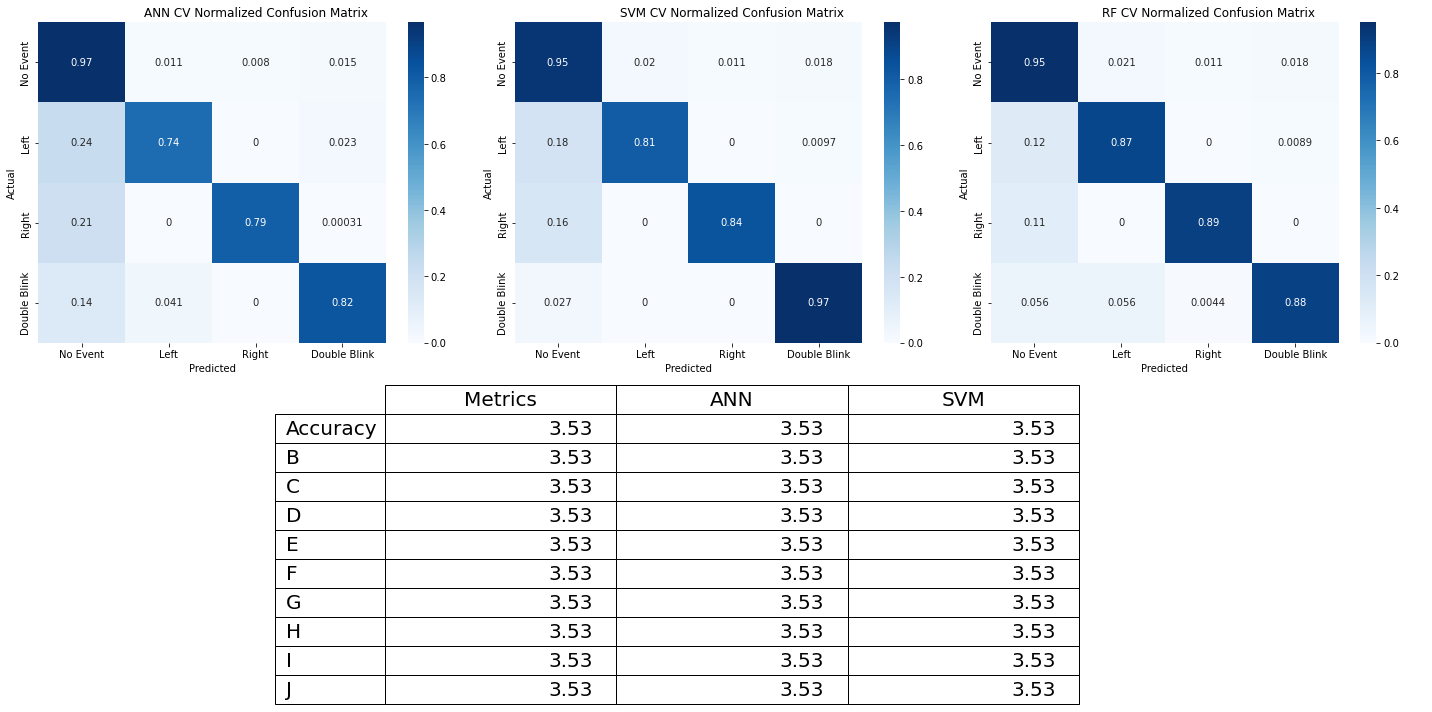

In [50]:
def plotConfMatrix2(models, model_names):
    fig = plt.figure(figsize=(20,10))
    plt.subplots_adjust(wspace=0.1, hspace=0.05)
    gs = fig.add_gridspec(2,3)
    
    # Normalize plots
    for index, model in enumerate(models):
        normalize = np.sum(model, axis=1)
        model = model/normalize.reshape(-1,1)
        ax = fig.add_subplot(gs[0, index])
        s = sns.heatmap(model, annot=True, cmap='Blues', ax=fig.add_subplot(gs[0,index]), 
                        xticklabels=['No Event', 'Left', 'Right', 'Double Blink'], 
                        yticklabels=['No Event', 'Left', 'Right', 'Double Blink'])
        s.set(xlabel='Predicted', ylabel='Actual')
        ax.set_title(f'{model_names[index]} CV Normalized Confusion Matrix')
        ax.xaxis.set_ticklabels(['No Event', 'Left', 'Right', 'Double Blink'])
        ax.yaxis.set_ticklabels(['No Event', 'Left', 'Right', 'Double Blink'], rotation=0)
        ax.axis('off')
        ax.axis('tight')

    ax = fig.add_subplot(gs[1,:])
    columns = ('Metrics', 'ANN', 'SVM', 'RF')

    row_labels = [
        "Accuracy",
        "B",
        "C",
        "D",
        "E",
        "F",
        "G",
        "H",
        "I",
        "J"
    ]

    data = []
    for i in range(10):
        data.append([f"{3.53242424:.2f}", f"{3.53242424:.2f}", f"{3.53242424:.2f}"])
#     data = np.random.random((10,3)) #Insert data for all of the columns as array 

    table = ax.table(cellText=data, colLabels=columns, rowLabels=row_labels, loc='center')
    
    table.auto_set_font_size(False)
    table.set_fontsize(20) 
    table.scale(0.5, 2)
    
    ax.axis('tight')
    ax.axis('off')
    fig.tight_layout()
    
    plt.show()


plotConfMatrix2(
    [total_conf_ann, total_conf_svm, total_conf_rf],
    ['ANN', 'SVM', 'RF']
)

### 4.2. Part B

## 5. Discussion and Conclusion

### 5.1. Issues Addressed

### 5.2. Conclusion

## 6. Student Contribution

### 6.1. Matty

### 6.2. Ashwin

### 6.3. Marcus

### 6.4. Alex

### 6.5. Jingyu

### 6.9. Josh
